# Statistical Learning - Final Project
## Model Evaluation
This notebook showcases our evaluation process of the newly finetuned model using a test set of the data.

Link to dataset: https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail 

|Team member|Student ID|
|-----------|----------|
|Nguyễn Duy Đăng Khoa|21127078|
|Phạm Nguyễn Quốc Thanh|21127428|
|Nguyễn Vũ Minh Khôi|21127518|
|Âu Dương Khang|21127621|

## Import & install libraries

In [1]:
!pip install -q datasets
!pip install -q evaluate
!pip install -q rouge_score
!pip install -q bert_score

Create folder for dataset (Kaggle - optional)

In [6]:
!mkdir test_ds

In [7]:
!cp -r /kaggle/input/cnn-test-tokenized/test ./test_ds/

In [12]:
!ls test_ds

test


## Loading the data & sampling

In [2]:
# LOAD THE TOKENIZED DATASET IF AVAILABLE ON DISK
from datasets import Dataset

tokenized_test_dataset = Dataset.load_from_disk('/kaggle/working/test_ds/test')

In [3]:
test_ds = tokenized_test_dataset.train_test_split(test_size=0.001)['test']

Because of computation limitations, we can only run inference on a small subset of the dataset.

In [4]:
del tokenized_test_dataset
len(test_ds)

12

## Define metrics
We'll use **Rouge** and **BERTScore** as the chosen metrics, suitable for text summarization

In [29]:
import numpy as np
import evaluate

metric_rouge = evaluate.load("rouge")
metric_bertscore = evaluate.load("bertscore")


def compute_metrics(eval_pred, tokenizer):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = metric_rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    bert_result = metric_bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang='en')

    # prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    # result["gen_len"] = np.mean(prediction_lens)
    bert_result.pop('hashcode', None)
    return {k: round(v, 4) for k, v in result.items()}, {k: round(np.mean(v), 4) for k, v in bert_result.items()}
    #return result, bert_result

## Running inference & evaluation

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
path = "/kaggle/input/cnn_text_summarization/transformers/default/1/StatisticalLearning_FinetunedModel"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForSeq2SeqLM.from_pretrained(path)

In [7]:
inputs = tokenizer(test_ds['article'], return_tensors="pt", padding=True).input_ids
outputs = model.generate(inputs, max_new_tokens=100, do_sample=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (2284 > 512). Running this sequence through the model will result in indexing errors


In [8]:
test_ds.features

{'article': Value(dtype='string', id=None),
 'highlights': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [30]:
rouge_result, bertscore_result = compute_metrics((outputs, test_ds['labels']), tokenizer)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
rouge_result

{'rouge1': 0.425, 'rouge2': 0.2078, 'rougeL': 0.2885, 'rougeLsum': 0.2887}

In [32]:
bertscore_result

{'precision': 0.8945, 'recall': 0.8833, 'f1': 0.8887}

## Visualize the results

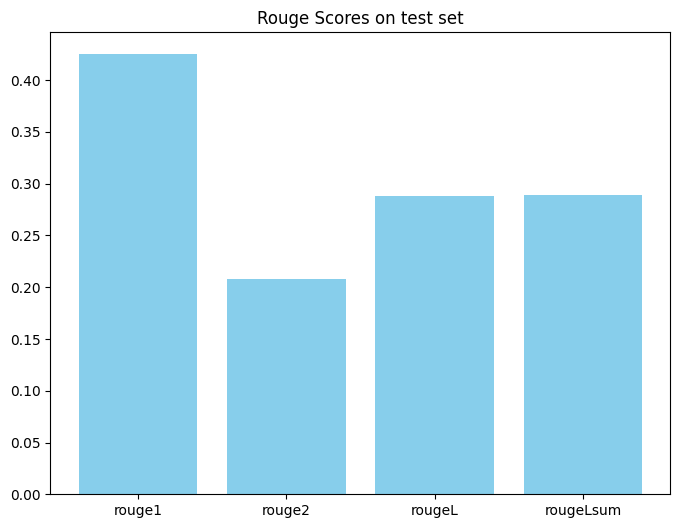

In [42]:
import matplotlib.pyplot as plt

# Sample dictionary
data = rouge_result

# Extract keys and values from the dictionary
keys = list(data.keys())
values = list(data.values())

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(keys, values, color='skyblue')

# Add labels and title
plt.title('Rouge Scores on test set')

# Show the plot
plt.savefig('./Rouge.png')
plt.show()

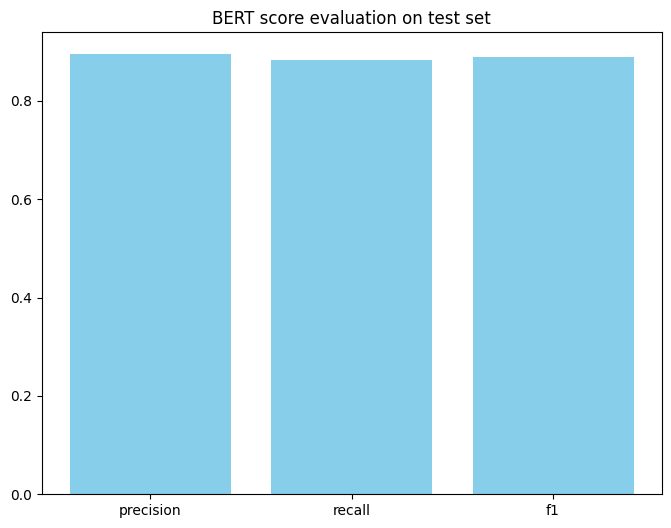

In [43]:
import matplotlib.pyplot as plt

# Sample dictionary
data = bertscore_result

# Extract keys and values from the dictionary
keys = list(data.keys())
values = list(data.values())

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(keys, values, color='skyblue')

# Add labels and title
plt.title('BERT score evaluation on test set')

# Show the plot
plt.savefig('./BERT.png')
plt.show()